In [1]:
import sys
sys.path.append('/home/emastr/phd/')

import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from stokes2d.robin_solver_scaled import testSolve, solveRobinStokes_fromFunc, solveRobinStokes_fromBasis
from util.basis_scaled import ScaleShiftedBasis
from util.basis_scaled import ScaleShiftedBasisProduct
from util.basis_scaled import FourBasis, BasisProduct, ChebBasis
from util.plot_tools import *
from boundary_solvers.geometry import MacroGeom
from boundary_solvers.gauss_grid_2d import StokesDirichletProblem
from scipy.io import loadmat
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import spsolve
from util.basis_scaled import Basis, ChebBasis, FourBasis, BasisProduct, ScaleShiftedBasis, ScaleShiftedBasisProduct
from util.gmres import gmres as torch_gmres

## Conclusions

GMRES doesn't work for solver since eigenvalues scattered on disk around zero.
Standard solver super fast for alpha = 0 but significantly slower (10x) otherwise.
Idea to iterate between Neumann and Dirichlet might work

In [2]:

############ TOOLS ####################################

def speye(n):
    return spdiags(np.ones(1, n), [0], (n, n))

def kron(A, B):
    cols = []
    for i in range(A.shape[1]):
        rows = []
        for j in range(A.shape[0]):
            rows.append(A[i,j] * B)
        cols.append(torch.vstack(rows))
    return torch.hstack(cols)

def sparse_coo(indx, data, *args, **kwargs):
    return sp.coo_matrix((data, indx), *args, **kwargs).tocsr()    

spdiags = lambda *args, **kwargs: sp.diags(*args, **kwargs).tocsr()
kron = lambda *args, **kwargs: sp.kron(*args, **kwargs).tocsr()
speye = lambda *args, **kwargs: sp.eye(*args, **kwargs).tocsr()

hstack = lambda *args, **kwargs: np.hstack(*args, **kwargs)
vstack = lambda *args, **kwargs: np.vstack(*args, **kwargs)

hstackSP = lambda *args, **kwargs: sp.hstack(*args, **kwargs)
vstackSP = lambda *args, **kwargs: sp.vstack(*args, **kwargs)

solve = lambda A, b: spsolve(A.tocsr(), b)
ones = lambda *args, **kwargs: np.ones(*args, **kwargs)
zeros = lambda *args, **kwargs: np.zeros(*args, **kwargs)
arange = lambda *args, **kwargs: np.arange(*args, **kwargs)

real = lambda x: np.real(x)
imag = lambda x: np.imag(x)

def flip(vec):
    return vec[::-1]

def solveRobinStokes_fromBasis(f, g, alpha, uTop, beta, vTop, vBot, dom, xDim, yDim, **kwargs):
    """Solve from Basis Function objects"""
    uC,vC,info = solveRobinStokes(f.basis.coef, g.basis.coef, alpha.basis.coef, uTop.basis.coef, beta.basis.coef, vTop.basis.coef, vBot.basis.coef, dom, xDim, yDim, **kwargs)
    
    u = BasisProduct(uC, xDim, yDim, FourBasis, ChebBasis)
    v = BasisProduct(vC, xDim, yDim, FourBasis, ChebBasis)
    
    scale, shift = ScaleShiftedBasisProduct._domain_to_scale_shift(u.domain(), dom)
    ub = ScaleShiftedBasisProduct(u, scale, shift)
    vb = ScaleShiftedBasisProduct(v, scale, shift)
    
    return ub, vb, info


def solveRobinStokes(f, g, alpha, uTop, beta, vTop, vBot, dom, Nx, Ny, with_gmres=False, **gmresargs):
    """SOLVEROBINSTOKES   Solve 1-periodic Stokes equations on 2D domain [0,Lx]x[0, Ly].
     The inputs must be ChebFourFun - objects.

     f:[0,Lx]x[0,Ly] -> R  force in u-direction
     g:[0,Lx]x[0,Ly] -> R  force in v-direction
     alpha:[0,Lx] -> R     variable shear constant
     uTop:[0,Lx] -> R      Dirichlet condition for u at y=1
     beta:[0,Lx] -> R      Inhom robin condition for u at y=-1
     vTop:[0,Lx] -> R      Dirichlet condition for v at y=1
     vBot:[0,Lx] -> R      Dirichlet condition for v at y=-1

     solveRobinStokes then solves The following boundary value problem:

         PDE: Moment equations
           (DxDx + DyDy)*u - Dx*p = f on [0,Lx]x[0,Ly]
           (DxDx + DyDy)*v - Dy*p = g on [0,Lx]x[0,Ly]
         PDE: Continuity Equations
                      Dx*u + Dy*v = 0 on [0,Lx]x[0,Ly]
         BC: Boundary conditions
                         u - uTop = 0 on [0,Lx]x{1}
            u + alpha*Dy*u - beta = 0 on [0,Lx]x{-1}
                         v - vTop = 0 on [0,Lx]x{1}
                         v - vBot = 0 on [0,Lx]x{-1}
     Returns
      u, v. p must be solved using a pressure solver."""
    
    
    info = {"Dim": (Nx, Ny)}
    kmax = (Nx-1) // 2
    
    dom_from = [FourBasis._domain(), ChebBasis._domain()]
    scale, _ = ScaleShiftedBasisProduct._domain_to_scale_shift(dom_from, dom)
    Lx = scale[0]
    Ly = scale[1]
                                                                   
    
    # Make sure the dimensions match. Truncate or zero pad.
    f = f.reshape(Nx, Ny)
    g = g.reshape(Nx, Ny)
    alpha = alpha.reshape(Nx,1)
    uTop = uTop.reshape(Nx,1)
    beta = beta.reshape(Nx,1)
    vTop = vTop.reshape(Nx,1)
    vBot = vBot.reshape(Nx,1) 
    
    t = time.time()
    # Laplace system 
    ns = arange(0, Ny)
    ks = arange(-kmax,kmax+1)
    cn = lambda n: 1. + (n==0) 
    # To correct low order coefficients!

    # Inverse d/dy matrix
    nVals = arange(1,Ny)[None, :]
    dyValm1 = cn(nVals-1) / (2*nVals)
    dyValp1 = -1 / (2*nVals)
    iDy = spdiags(vstack([dyValm1, dyValp1]), [0,2], (Ny-1,Ny)) * Ly

    # Inverse dd/ddy matrix
    nVals = arange(2,Ny)[None, :]
    ddyValp2 = 1./(4.*nVals * (nVals+1))
    ddyVal0  = -1./(2.*(nVals ** 2 - 1))
    ddyValm2 = cn(nVals-2)/(4 * nVals * (nVals-1))
    iDy2 = spdiags(vstack([ddyValm2, ddyVal0, ddyValp2]), \
                         [0,2,4], (Ny-2, Ny)) * Ly ** 2

    
    # Inverse ddd/dddy matrix
    nVals = arange(3, Ny)[None, :]
    dddyValp3 = -1 / (8*nVals * (nVals+1) * (nVals+2))
    dddyValp1 =  3 / (8*(nVals+2) * nVals * (nVals-1))
    dddyValm1 = -3 / (8*(nVals-2) * nVals *(nVals+1)) 
    dddyValm3 = cn(nVals-3) / (8*nVals * (nVals-1) * (nVals-2))

    iDy3 = spdiags(vstack([dddyValm3, dddyValm1, dddyValp1, dddyValp3]),\
                          [0,2,4,6], (Ny-3, Ny)) * Ly ** 3

    Dx  = spdiags((2j*np.pi*(ks[None, :])) ** 1, [0], (Nx, Nx)) / Lx**1
    Dx2 = spdiags((2j*np.pi*(ks[None, :])) ** 2, [0], (Nx, Nx)) / Lx**2
    Dx3 = spdiags((2j*np.pi*(ks[None, :])) ** 3, [0], (Nx, Nx)) / Lx**3

    Idx  = speye(Nx)
    Idy  = spdiags(ones((1, Ny-1)), [1], (Ny-1, Ny))
    Idy2 = spdiags(ones((1, Ny-2)), [2], (Ny-2, Ny))
    Idy3 = spdiags(ones((1, Ny-3)), [3], (Ny-3, Ny))

    # Eval
    botEval = kron(Idx, (-1) ** ns)
    
    topEval = kron(Idx, ones(ns.shape))
    dirZero = sparse_coo([[], []], [], (Nx, Ny*Nx))

    # Create B_upper
    AMat = spdiags(flip(alpha).repeat(Nx, 1), ks, (Nx, Nx))
    
    dyEval  = ((ns ** 2) *(-1) ** (ns+1)) / Ly
    botRobi = botEval + kron(AMat, dyEval)
    botRobi2 = botEval
    
    unit_const = (ks == 0)
    zero_const = sparse_coo([[],[]],[],((Ny-2),Nx*Ny))
    
    # B system
    #print(By.shape, By2.shape, By.shape)
    B11 = kron(Dx2[:kmax,:], iDy2[1:, :])+kron(Idx[:kmax,:], Idy3)
    B12 = -(kron(Dx3[:kmax,:], iDy3)+kron(Dx[:kmax,:], iDy[2:, :]))
    B21 = kron(unit_const, Idy2)
    B22 = zero_const
    B31 = kron(Dx2[kmax+1:,:], iDy2[1:, :])+kron(Idx[kmax+1:,:], Idy3)
    B32 = -(kron(Dx3[kmax+1:,:], iDy3)+kron(Dx[kmax+1:,:],iDy[2:, :]))
    B41 = kron(Dx, iDy)
    B42 = kron(Idx, Idy)
                  
    B_pde = vstackSP([hstackSP([B11, B12]),
                      hstackSP([B21, B22]),
                      hstackSP([B31, B32]),
                      hstackSP([B41, B42])])
    
    
    #### BUG? ####
    # MIGHT HAVE TO PERMUTE f.C DIMENSIONS
    ##############
    
    b_mom = kron(Idx, iDy2[1:,:]) @ f.reshape(Ny*Nx, 1) \
                  - kron(Dx, iDy3) @ g.reshape(Ny*Nx, 1)
    b_pde = vstack([b_mom[0:(kmax*(Ny-3)),:],
                      iDy2 @ (f[kmax,:, None]),
                      b_mom[(kmax+1)*(Ny-3):,:],
                      zeros(((Ny-1)*Nx,1))])

    B_dir = vstackSP([hstackSP([botRobi, dirZero]),\
                      hstackSP([dirZero, botEval]),\
                      hstackSP([topEval, dirZero]),\
                      hstackSP([dirZero[ks!=0,:], topEval[ks!=0, :]])\
                    ])
    
    B_dir2 = vstackSP([hstackSP([botRobi2, dirZero]),\
                      hstackSP([dirZero, botEval]),\
                      hstackSP([topEval, dirZero]),\
                      hstackSP([dirZero[ks!=0,:], topEval[ks!=0, :]])\
                    ])

    b_dir = vstack([beta, vBot, uTop, vTop[ks!=0,:]])
    
    # solve
    B = vstackSP([B_pde, B_dir])
    B2 = vstackSP([B_pde, B_dir2])
    b = vstack([b_pde, b_dir])
    
    info["buildTime"] = time.time() - t;
    b_ri = vstack([real(b), imag(b)])
    B_ri = vstackSP([hstackSP([real(B2), -imag(B2)]),
                     hstackSP([imag(B2), real(B2)])])
    
    t = time.time()
    if not with_gmres:
        uv = solve(B, b)
    else:
        #print(np.linalg.cond(B.todense()))
        #print(np.linalg.cond(B2.todense()))
        #def cb(x):
        #    #print(np.linalg.norm(B @ x - b), end="\r")
        #    print(x, end='\r')
        #uv_ri, _ = gmres(B_ri.todense(), b_ri, tol=1e-3, callback=cb, callback_type='pr_norm')
        #uv = uv_ri[:len(uv_ri)//2] + 1j * uv_ri[len(uv_ri)//2:]
        
        Bt = torch.Tensor(B_ri.todense())
        bt = torch.Tensor(b_ri)[None, :, 0]
        B_op = lambda x: torch.tensordot(x, Bt, dims=[[1], [1]])
        
        #print(bt.shape)
        #print(B_op(bt).shape)
        uv_ri = torch_gmres(B_op, bt, steps=98).numpy().T
        uv = uv_ri[:len(uv_ri)//2] + 1j * uv_ri[len(uv_ri)//2:]
        
        print(np.linalg.norm(B2 @ uv - b) / np.linalg.norm(b))
        plt.plot(uv)
        plt.plot(solve(B, b))
        
    info["solveTime"] = time.time() - t
    info["B"] = B
    info["b"] = b
    info["B2"] = B2
    info["B_ri"] = B_ri
    
    L = Nx*Ny
    idx = arange(0, L)
    uC = uv[idx+0*L].reshape(Nx, Ny)
    vC = uv[idx+1*L].reshape(Nx, Ny)
    
   
    
    return uC, vC, info



In [7]:
xDim = 7
yDim = 7
plot = True
kwargs = {"dom": [[0.,1.],[-1.,1.]]}

#scale = [Lx, Ly/2]
#shift = [0,0]
dom = kwargs.pop("dom", [[0., 1.], [-1., 1.]])

Lx = dom[0][1]-dom[0][0]
Ly = dom[1][1]-dom[1][0]

xBasis = FourBasis
yBasis = ChebBasis

psi = lambda x, y: np.exp(y*np.cos(2*np.pi*x / Lx))
p = lambda x,y: 1. / ((y/Ly)**2 + 1) * np.arctan(np.cos(2*np.pi*x / Lx))
a = lambda x: 1. / (np.sin(2*np.pi*x/Lx)+2)


p_basis = ScaleShiftedBasisProduct.fromFunctionInDomain(p, dom, xDim, yDim, xBasis, yBasis)
psi_basis = ScaleShiftedBasisProduct.fromFunctionInDomain(psi, dom, xDim, yDim, xBasis, yBasis)
alpha_basis = ScaleShiftedBasis.fromFunctionInDomain(a, dom[0], xBasis, xDim)

# U and V velocity components
u_basis = psi_basis.diff(0, 1)
v_basis = -1. * psi_basis.diff(1, 0)

# Divergence field
div_basis = u_basis.diff(1, 0) + v_basis.diff(0, 1)

# Laplacian and pressure gradients
lapu_basis = u_basis.diff(2, 0) + u_basis.diff(0, 2)
lapv_basis = v_basis.diff(2, 0) + v_basis.diff(0, 2)
dxp_basis = p_basis.diff(1,0)
dyp_basis = p_basis.diff(0,1)


### Problem parameters

# Inner force
f_basis = lapu_basis - dxp_basis
g_basis = lapv_basis - dyp_basis

# PDE x component
pde_basis = lapu_basis - dxp_basis - f_basis

# Upper boundary condition
uTop_basis = u_basis.reduce_eval(dom[1][1], axis=1)
vTop_basis = v_basis.reduce_eval(dom[1][1], axis=1)


# Lower boundary velocities
uBot_basis = u_basis.reduce_eval(dom[1][0], axis=1)
vBot_basis = v_basis.reduce_eval(dom[1][0], axis=1)


# Lower boundary slip coefficient
duBot_basis = u_basis.diff(0,1).reduce_eval(dom[1][0], axis=1)
beta_basis = uBot_basis + alpha_basis * duBot_basis



uSol_basis,vSol_basis,info = solveRobinStokes_fromBasis(f_basis, 
                                                        g_basis, 
                                                        alpha_basis, 
                                                        uTop_basis, 
                                                        beta_basis, 
                                                        vTop_basis, 
                                                        vBot_basis,
                                                        dom, xDim, yDim)


In [8]:
B = info["B"]
#B = info["B_ri"]
B2 = info["B2"]
b = info["b"]

t = time.time()
solve(B, b)
t = time.time() - t

t2 = time.time()
solve(B2, b)
t2 = time.time() - t2



print(t, t2, info["buildTime"])
#plt.figure(figsize=(20,20))
#plt.imshow(np.log(np.abs((B).todense())), vmin=-3, vmax=3)

0.0023505687713623047 0.0005228519439697266 0.012295961380004883


7293.713175947989
3.483633278984672


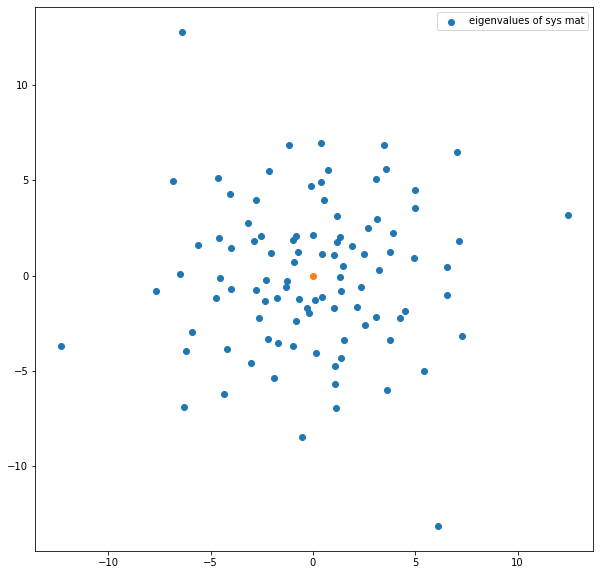

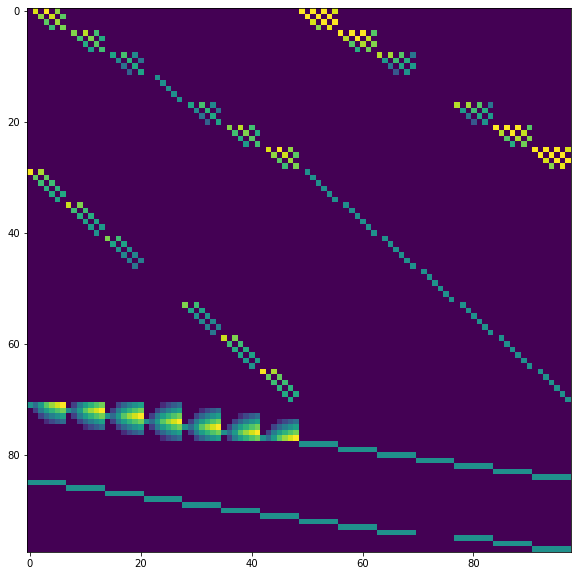

In [11]:
import scipy

#x = solve(B, b)
Bp2 = B
eig, vec = scipy.linalg.eig(Bp2.todense())
_, svd, _ = np.linalg.svd(B.todense())
eig2 = (Bp2 @ vec)[40, :] / vec[40, :]
B_dig = np.linalg.solve(vec.T, np.diag(eig).T @ vec.T).T
print(np.linalg.cond(B.todense(), p=2))
print((max(np.abs(eig)) / min(np.abs(eig)))**0.5)

plt.figure(figsize=(10,10))
plt.scatter(real(eig), imag(eig), label='eigenvalues of sys mat')
plt.scatter(0, 0)
plt.legend()

plt.figure(figsize=(10,10))
plt.imshow(np.log(np.abs(B_dig)), vmin=-3, vmax=3)
